## Churn Prediction with Scikit-learn package

### Import packages and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mutual_info_score, accuracy_score, roc_auc_score, roc_curve,ConfusionMatrixDisplay
from sklearn.feature_extraction import DictVectorizer
from IPython.display import display
import warnings
from sklearn.exceptions import ConvergenceWarning

In [2]:
df= pd.read_csv('data.csv')

### Data Cleaning

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [5]:
df.columns = df.columns.str.lower().str.replace(' ','_')

In [6]:
df.dtypes

customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges         object
churn                object
dtype: object

In [7]:
df.totalcharges = pd.to_numeric(df.totalcharges,errors = 'coerce')

In [8]:
numericals = ['tenure', 'monthlycharges', 'totalcharges']
categorical = ['gender', 'partner', 'dependents',
       'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']

In [9]:
for c in categorical:
    df[c] = df[c].str.lower().str.replace(' ','_')

In [10]:
df.isnull().sum()

customerid           0
gender               0
seniorcitizen        0
partner              0
dependents           0
tenure               0
phoneservice         0
multiplelines        0
internetservice      0
onlinesecurity       0
onlinebackup         0
deviceprotection     0
techsupport          0
streamingtv          0
streamingmovies      0
contract             0
paperlessbilling     0
paymentmethod        0
monthlycharges       0
totalcharges        11
churn                0
dtype: int64

In [11]:
df.totalcharges = df.totalcharges.fillna(0)

In [12]:
df.churn = (df.churn == 'Yes').astype(int)
df.churn.head()

0    0
1    0
2    1
3    0
4    1
Name: churn, dtype: int64

### Exploratory Data Analysis

In [13]:
numericals = ['tenure', 'monthlycharges', 'totalcharges']
categorical = ['gender','seniorcitizen', 'partner', 'dependents',
       'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']

In [14]:
df.churn.mean() ### this gives the percentage of people who have switched networks

np.float64(0.2653698707936959)

In [15]:
df[categorical].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

### Feature Importance Identification

#### Churn Rate and Risk Ratio

In [16]:
for c in categorical:
    print(c)
    df_group = df.groupby(c).churn.agg(['count','mean'])
    df_group['churn rate'] = df_group['mean'] - df.churn.mean()
    df_group['risk ratio'] = df_group['mean'] / df.churn.mean()
    display(df_group)
    print()

gender


,count,mean,churn rate,risk ratio
gender,,,,
female,3488,0.269209,0.003839,1.014466
male,3555,0.261603,-0.003766,0.985807



seniorcitizen


,count,mean,churn rate,risk ratio
seniorcitizen,,,,
0,5901,0.236062,-0.029308,0.889557
1,1142,0.416813,0.151443,1.570686



partner


,count,mean,churn rate,risk ratio
partner,,,,
no,3641,0.329580,0.064210,1.241964
yes,3402,0.196649,-0.068721,0.741038



dependents


,count,mean,churn rate,risk ratio
dependents,,,,
no,4933,0.312791,0.047422,1.178700
yes,2110,0.154502,-0.110868,0.582215



phoneservice


,count,mean,churn rate,risk ratio
phoneservice,,,,
no,682,0.249267,-0.016103,0.939319
yes,6361,0.267096,0.001726,1.006506



multiplelines


,count,mean,churn rate,risk ratio
multiplelines,,,,
no,3390,0.250442,-0.014927,0.943749
no_phone_service,682,0.249267,-0.016103,0.939319
yes,2971,0.286099,0.020729,1.078114



internetservice


,count,mean,churn rate,risk ratio
internetservice,,,,
dsl,2421,0.189591,-0.075779,0.714441
fiber_optic,3096,0.418928,0.153558,1.578656
no,1526,0.074050,-0.191320,0.279044



onlinesecurity


,count,mean,churn rate,risk ratio
onlinesecurity,,,,
no,3498,0.417667,0.152297,1.573906
no_internet_service,1526,0.074050,-0.191320,0.279044
yes,2019,0.146112,-0.119258,0.550597



onlinebackup


,count,mean,churn rate,risk ratio
onlinebackup,,,,
no,3088,0.399288,0.133918,1.504645
no_internet_service,1526,0.074050,-0.191320,0.279044
yes,2429,0.215315,-0.050055,0.811377



deviceprotection


,count,mean,churn rate,risk ratio
deviceprotection,,,,
no,3095,0.391276,0.125906,1.474456
no_internet_service,1526,0.074050,-0.191320,0.279044
yes,2422,0.225021,-0.040349,0.847951



techsupport


,count,mean,churn rate,risk ratio
techsupport,,,,
no,3473,0.416355,0.150985,1.568960
no_internet_service,1526,0.074050,-0.191320,0.279044
yes,2044,0.151663,-0.113706,0.571517



streamingtv


,count,mean,churn rate,risk ratio
streamingtv,,,,
no,2810,0.335231,0.069861,1.263261
no_internet_service,1526,0.074050,-0.191320,0.279044
yes,2707,0.300702,0.035332,1.133143



streamingmovies


,count,mean,churn rate,risk ratio
streamingmovies,,,,
no,2785,0.336804,0.071434,1.269188
no_internet_service,1526,0.074050,-0.191320,0.279044
yes,2732,0.299414,0.034044,1.128291



contract


,count,mean,churn rate,risk ratio
contract,,,,
month-to-month,3875,0.427097,0.161727,1.609440
one_year,1473,0.112695,-0.152675,0.424672
two_year,1695,0.028319,-0.237051,0.106714



paperlessbilling


,count,mean,churn rate,risk ratio
paperlessbilling,,,,
no,2872,0.163301,-0.102069,0.615371
yes,4171,0.335651,0.070281,1.264842



paymentmethod


,count,mean,churn rate,risk ratio
paymentmethod,,,,
bank_transfer_(automatic),1544,0.167098,-0.098271,0.629681
credit_card_(automatic),1522,0.152431,-0.112939,0.574410
electronic_check,2365,0.452854,0.187484,1.706502
mailed_check,1612,0.191067,-0.074303,0.720003


#### Mutual Information

In [17]:
def mutual_info(column):
    return mutual_info_score(column,df.churn)
    

In [18]:
m_i = df[categorical].apply(mutual_info)
m_i.sort_values(ascending = False)

contract            0.098453
onlinesecurity      0.064677
techsupport         0.063021
internetservice     0.055574
onlinebackup        0.046792
paymentmethod       0.044519
deviceprotection    0.043917
streamingmovies     0.032001
streamingtv         0.031908
paperlessbilling    0.019194
dependents          0.014467
partner             0.011454
seniorcitizen       0.010577
multiplelines       0.000801
phoneservice        0.000072
gender              0.000037
dtype: float64

#### Correlation

In [19]:
df[numericals].corrwith(df.churn)

tenure           -0.352229
monthlycharges    0.193356
totalcharges     -0.198324
dtype: float64

### Split data into Train, Validation and Test sets

In [20]:
df_train_full,df_test = train_test_split(df,test_size = 0.2, random_state = 120)
df_train,df_val = train_test_split(df_train_full,test_size = 0.25, random_state =120) # test_size is 0.25 to get 20% of the full data

In [21]:
len(df_train),len(df_val),len(df_test)

(4225, 1409, 1409)

In [22]:
y_train = df_train.churn
y_val = df_val.churn
y_test = df_test.churn
del df_train['churn']
del df_val['churn']
del df_test['churn']

In [23]:
x_train = df_train.to_dict(orient = 'records')
x_val = df_val.to_dict(orient = 'records')
x_test = df_test.to_dict(orient = 'records')

### Encode Categorical Values

In [24]:
dv= DictVectorizer(sparse = False)

In [25]:
x_train = dv.fit_transform(x_train)
x_val = dv.transform(x_val)

### Logistic Regression

In [26]:
lr = LogisticRegression(random_state = 120)

In [27]:
lr.fit(x_train,y_train)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=120)

In [28]:
lr.intercept_[0]

np.float64(-0.12558670863212615)

In [29]:
lr.coef_[0].round(2)

array([ 0.55, -0.24, -0.43, ..., -0.21, -0.07,  0.  ], shape=(4270,))

In [30]:
train_pred = lr.predict_proba(x_train)[:,1]
churn_decision = (train_pred >= 0.5)
accuracy_score(y_train,churn_decision)


0.805207100591716

In [31]:
val_pred = lr.predict_proba(x_val)[:,1]
churn_decision = (val_pred >= 0.5)
accuracy_score(y_val,churn_decision)

0.808374733853797

#### Check for the optimal threshold

0.00 0.259
0.05 0.520
0.10 0.620
0.15 0.676
0.20 0.720
0.25 0.752
0.30 0.765
0.35 0.773
0.40 0.784
0.45 0.800
0.50 0.808
0.55 0.803
0.60 0.792
0.65 0.792
0.70 0.778
0.75 0.764
0.80 0.747
0.85 0.741
0.90 0.741
0.95 0.741
1.00 0.741


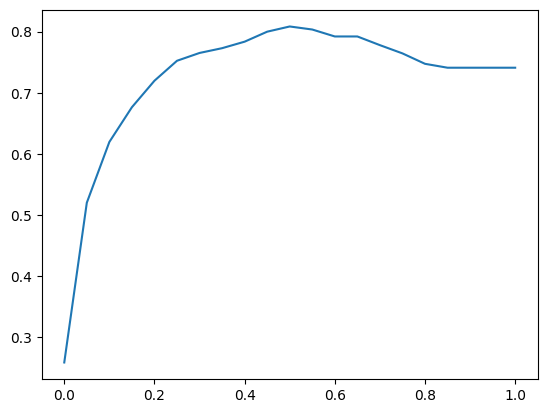

In [32]:
thresholds = np.linspace(0,1,21)
scores = []
for t in thresholds:
    churn_decision = (val_pred >= t)
    acc = accuracy_score(y_val,churn_decision)
    scores.append(acc)
    print('%.2f %.3f' % (t,acc))
plt.plot(thresholds,scores)

In [33]:
n_pos = (y_val == 1).sum()
n_neg = (y_val == 0).sum()
n_pos, n_neg

(np.int64(365), np.int64(1044))

##### Note:
* It happened that the optimal threshold was 0.5 which was already being used.
* But it is important to note that a dummy model which has a threshold of 1 (that means predicts every user as not churning) has an accuracy of 74%
* This is just 6% lesser than the optimal trained model
* This is because of the class imbalance problem within the data. In such cases, accuracy alone as a metric can be misleading
* So, other metrics should also be considered

### Confusion Matrix

In [34]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)
pred_positive = (val_pred >= 0.5)
pred_negative = (val_pred < 0.5)
tp = (actual_positive & pred_positive).sum()
tn = (actual_negative & pred_negative).sum()
fp = (actual_negative & pred_positive).sum()
fn = (actual_positive & pred_negative).sum()
tp,tn,fp,fn

(np.int64(211), np.int64(928), np.int64(116), np.int64(154))

### Precision and Recall

In [35]:
precision = tp/ (tp+fp)
precision

np.float64(0.6452599388379205)

In [36]:
recall = tp/(tp+fn)
recall

np.float64(0.5780821917808219)

### ROC Curve and AUC

In [37]:
fpr,tpr,thresholds = roc_curve(y_val,val_pred)


Text(0.5, 1.0, 'ROC Curve')

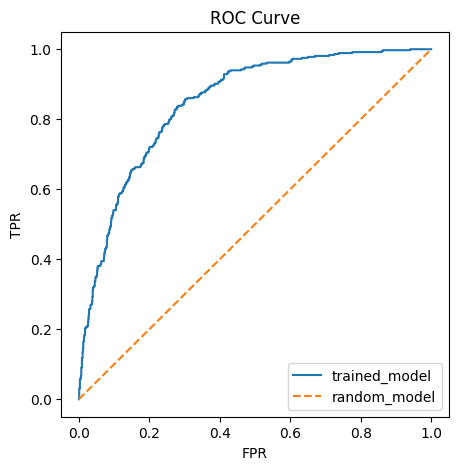

In [38]:
plt.figure(figsize = (5,5))
plt.plot(fpr,tpr,label = 'trained_model')
plt.plot([0,1],[0,1],label = 'random_model',linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ROC Curve')

In [39]:
auc = roc_auc_score(y_val,val_pred)
auc

np.float64(0.8479885057471264)

##### Note:
* The other metrics except accuracy show that the model is not a very great model and is just performing above average
* This proves that considering accuracy alone in cases of class imbalance data would be misleading

### Regularization parameter tuning with KFold Cross validation

In [40]:
def train(df_train,y_train,C = 1):
    x_train = df_train.to_dict(orient = 'records')
    dv = DictVectorizer(sparse = False)
    x_train = dv.fit_transform(x_train)
    model = LogisticRegression(random_state = 120,C=C)
    model.fit(x_train,y_train)
    return dv,model

In [41]:
def predict(dv,model,df_val):
    x_val = df_val.to_dict(orient = 'records')
    x_val = dv.transform(x_val)
    y_pred = model.predict_proba(x_val)[:,1]
    return y_pred

In [42]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
n_splits = 10
for C in [0.001, 0.01, 1, 5, 10]:
    scores = []
    kfold = KFold(n_splits = n_splits,shuffle = True, random_state = 120)
    df_full_train = df_train_full.copy()
    for train_idx,val_idx in (kfold.split(df_full_train)):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        y_train = df_train.churn.values
        y_val = df_val.churn.values
        del df_train['churn']
        del df_val['churn']
        dv,model = train(df_train,y_train,C)
        y_pred = predict(dv,model,df_val)
        auc = roc_auc_score(y_val,y_pred)
        scores.append(auc)
    print('%s %.3f +- %.2f' % (C,np.mean(scores),np.std(scores)))

0.001 0.829 +- 0.01
0.01 0.844 +- 0.01
1 0.845 +- 0.01
5 0.845 +- 0.01
10 0.845 +- 0.01


#### Note
* C = 1 is the best regularization parameter
* Further, this tuning can be done with the basic holdout validation data method as well.
* Here it is implemented with KFold CV to look for improvements paralelly.
* A point to note is that the standard deviation is almost very small which means the model generalizes
* We will continue with this model for testing and deploying to production though it is not a super good model

### Testing for generalizability in test data

In [43]:
y_full_train = df_train_full.churn.values
del df_train_full['churn']

In [44]:
dv,model = train(df_train_full,y_full_train,C=0.01)
y = predict(dv,model,df_test)
y_pred = (y >= 0.5)

METRICS
Accuracy:  0.8062455642299503


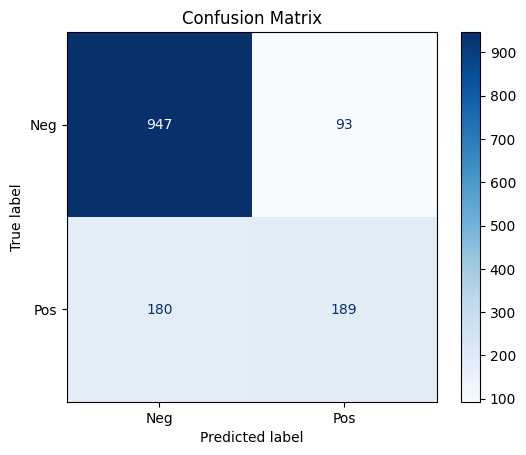

Precision:  0.6702127659574468
Recall:  0.5121951219512195
AUC:  0.838290858870127


In [45]:
acc = accuracy_score(y_test,y_pred)
actual_positive = (y_test == 1)
actual_negative = (y_test == 0)
pred_positive = (y_pred >= 0.5)
pred_negative = (y_pred < 0.5)
tp = (actual_positive & pred_positive).sum()
tn = (actual_negative & pred_negative).sum()
fp = (actual_negative & pred_positive).sum()
fn = (actual_positive & pred_negative).sum()
conf_mat = np.array([[tn,fp],
                    [fn,tp]])
precision = tp/(tp+fp)
recall = tp/(tp+fn)
print('METRICS')
print('Accuracy: ',acc)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=['Neg', 'Pos'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
print('Precision: ',precision)
print('Recall: ',recall)
print('AUC: ',roc_auc_score(y_test,y))

### The model can now be deployed, since the model performs almost similar in the unseen test set!!!